In [1]:
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import numpy as np
#from sklearn.metrics import plot_confusion_matrix
import re
import matplotlib.pyplot as plt
import sklearn  as sk

In [2]:
path = os.getcwd()
print(path)

/Users/Guillaume/Desktop/RemiseNiveau


In [3]:
path_data = path + '/' + 'train_E6oV3lV.csv'
data = pd.read_csv(path_data)

In [4]:
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Text(0.5, 0, 'Class')

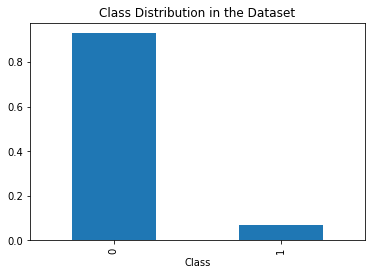

In [5]:
data["label"].value_counts(normalize=True).plot(kind="bar")
plt.title("Class Distribution in the Dataset")
plt.xlabel("Class")

Split randomly the dataset into a training and test sets

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data["label"], test_size=0.33, random_state=42)

## Text processing with nltk and re

Processing relies on four main steps:

*   Lower
*   Remove Punctuations and Stopwords
- Stemming
- Tokenization

In [7]:
nltk.download("stopwords")
stopwords_list = stopwords.words("english")
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Guillaume/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def process_tweet(tweet, stopwords_list):
    '''
      This function processes a tweet to make it understable for modeling.
      Input:
        tweet: a sentence as strings
        stopword_list : list of stopwords
    '''
  # Lowercase
    tweet = tweet.lower()
  #Remove tags, hastags and internet links
    tweet = re.sub(r"#(\w+)", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r"@(\w+)", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r"https(\w+)", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r"http(\w+)", '', tweet, flags=re.MULTILINE)

  #Remove punctuation
    tweet = re.sub(r"[^\w\s]", '', tweet)
  #Remove empty space
    tweet = re.sub(" +", " ", tweet)

  # Tokenize and remove stopwords
    tweet = tweet.split()
    tweet = [word for word in tweet if not word in stopwords_list]

  # Stemming
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet]

    return tweet

In [9]:
tweet_test = X_train[0]
print("Original Tweet: ", tweet_test)
tweet_process = process_tweet(tweet_test, stopwords_list)
print("Processed Tweet: ", tweet_process)

Original Tweet:   @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
Processed Tweet:  ['father', 'dysfunct', 'selfish', 'drag', 'kid', 'dysfunct']


In [10]:
def build_freqs(x, y, stopwords_list):
    '''
      Build a dictionnary of which keys are tuple (word, label) and the corresponding values refer to 
      the count in all documents.
      Input:
        x : list of sentences
        y : list of labels
        stopwords_list : list of stopwords
      '''
    freqs = dict()
    for tweet, label in zip(x, y):
        for word in process_tweet(tweet, stopwords_list):
            pair = (word, label)
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs

In [11]:
freqs = build_freqs(X_train, y_train, stopwords_list)

In [12]:
V = len(set([pair[0] for pair in freqs.keys()]))
print("The size of vocabulary after processing is: ", V)

The size of vocabulary after processing is:  16686


In [13]:
def build_vector_tweet(dict_freq, train_x, stopwords_list):
    '''
      Build for each tweet a vector understandable for logistic regression model
      Input: 
        dict_freq: dictionnary of frequencies from the functionbuild_freqs
        train_x: list of sentences
        stopwords_list: list of stopwords
      '''
    result = []
    for tweet in train_x:
        tweet = process_tweet(tweet, stopwords_list)
        freq_pos = 0
        frq_neg = 0
        for word in tweet:
            freq_pos =+ dict_freq.get((word,0), 0)
            freq_neg =+ dict_freq.get((word,1), 0)
    
        result.append([1, freq_pos, freq_neg])
    return result

## Training of Logistic Regression

In [14]:
train_x_lr = build_vector_tweet(freqs, X_train, stopwords_list)
train_x_lr = np.array(train_x_lr)
train_y_lr = np.array(y_train)

In [15]:
lr = sk.linear_model.LogisticRegression(penalty='l2', fit_intercept=False)

In [16]:
lr.fit(train_x_lr, train_y_lr)

LogisticRegression(fit_intercept=False)

In [17]:
y_hat_train = lr.predict(train_x_lr)
score = np.mean(y_hat_train==train_y_lr)
print("Accuracy of the model is: ", round(score,2))

Accuracy of the model is:  0.93


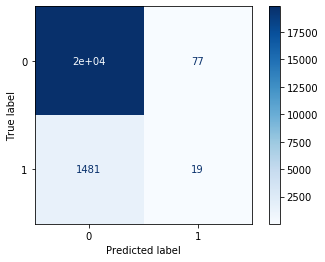

In [18]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr, train_x_lr, train_y_lr,
                                 cmap=plt.cm.Blues)